In [4]:
import time
import jwt
import requests
import os 

os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'

# 实际KEY，过期时间
def generate_token(apikey: str, exp_seconds: int):
    try:
        id, secret = apikey.split(".")
    except Exception as e:
        raise Exception("invalid apikey", e)

    payload = {
        "api_key": id,
        "exp": int(round(time.time() * 1000)) + exp_seconds * 1000,
        "timestamp": int(round(time.time() * 1000)),
    }
    return jwt.encode(
        payload,
        secret,
        algorithm="HS256",
        headers={"alg": "HS256", "sign_type": "SIGN"},
    )

url = "https://open.bigmodel.cn/api/paas/v4/chat/completions"
headers = {
  'Content-Type': 'application/json',
  'Authorization': generate_token("", 1000)
}

data = {
    "model": "glm-4",
    "messages": [{"role": "user", "content": """你好"""}]
}

response = requests.post(url, headers=headers, json=data)

print("Status Code", response.status_code)
print("JSON Response ", response.json())

Status Code 200
JSON Response  {'choices': [{'finish_reason': 'stop', 'index': 0, 'message': {'content': '你好👋！我是人工智能助手智谱清言，可以叫我小智🤖，很高兴见到你，欢迎问我任何问题。', 'role': 'assistant'}}], 'created': 1726544496, 'id': '202409171141353307788d9d684753', 'model': 'glm-4', 'request_id': '202409171141353307788d9d684753', 'usage': {'completion_tokens': 32, 'prompt_tokens': 6, 'total_tokens': 38}}


In [5]:
import json
import pdfplumber

# 加载问题和Pdf
questions = json.load(open("./data/questions.json"))
print(questions[0])

pdf = pdfplumber.open(r"data\初赛训练数据集.pdf")
len(pdf.pages)
print(pdf.pages[0].extract_text())


{'question': '“前排座椅通风”的相关内容在第几页？', 'answer': '', 'reference': ''}
欢迎
感谢您选择了具有优良安全性、舒适性、动力性和经济性的Lynk&Co领克汽车。
首次使用前请仔细、完整地阅读本手册内容，将有助于您更好地了解和使用车辆。
本手册中的所有资料均为出版时的最新资料，但本公司将对产品进行不断的改进和优化，您所购的车辆可能与本手册中的描述有所不同，请以实际
接收的车辆为准。
如您有任何问题，或需要预约服务，请拨打电话4006-010101联系我们。您也可以开车前往Lynk&Co领克中心。
在抵达之前，请您注意驾车安全。
©领克汽车销售有限公司


In [6]:

pdf_contents = []
for page_idx in range(len(pdf.pages)):
    pdf_contents.append({'page':'page_'+str(page_idx+1),
                         'content': pdf.pages[page_idx].extract_text()
                         })

print(pdf_contents[0])


{'page': 'page_1', 'content': '欢迎\n感谢您选择了具有优良安全性、舒适性、动力性和经济性的Lynk&Co领克汽车。\n首次使用前请仔细、完整地阅读本手册内容，将有助于您更好地了解和使用车辆。\n本手册中的所有资料均为出版时的最新资料，但本公司将对产品进行不断的改进和优化，您所购的车辆可能与本手册中的描述有所不同，请以实际\n接收的车辆为准。\n如您有任何问题，或需要预约服务，请拨打电话4006-010101联系我们。您也可以开车前往Lynk&Co领克中心。\n在抵达之前，请您注意驾车安全。\n©领克汽车销售有限公司'}


# 文本检索与答案检索
文本检索是一个多步骤的过程，其核心是构建倒排索引以实现高效的文本检索：
- 步骤1（文本预处理）：在文本预处理阶段，对原始文本进行清理和规范化，包括去除停用词、标点符号等噪声，并将文本统一转为小写。接着，采用词干化或词形还原等技术，将单词转换为基本形式，以减少词汇的多样性，为后续建立索引做准备。
- 步骤2（文本索引）：构建倒排索引是文本检索的关键步骤。通过对文档集合进行分词，得到每个文档的词项列表，并为每个词项构建倒排列表，记录包含该词项的文档及其位置信息。这种结构使得在查询时能够快速找到包含查询词的文档，为后续的文本检索奠定了基础。
- 步骤3（文本检索）：接下来是查询处理阶段，用户查询经过预处理后，与建立的倒排索引进行匹配。计算查询中每个词项的权重，并利用检索算法（如TFIDF或BM25）对文档进行排序，将相关性较高的文档排在前面。
下面是文本检索和语义检索的区别和联系的表格形式：
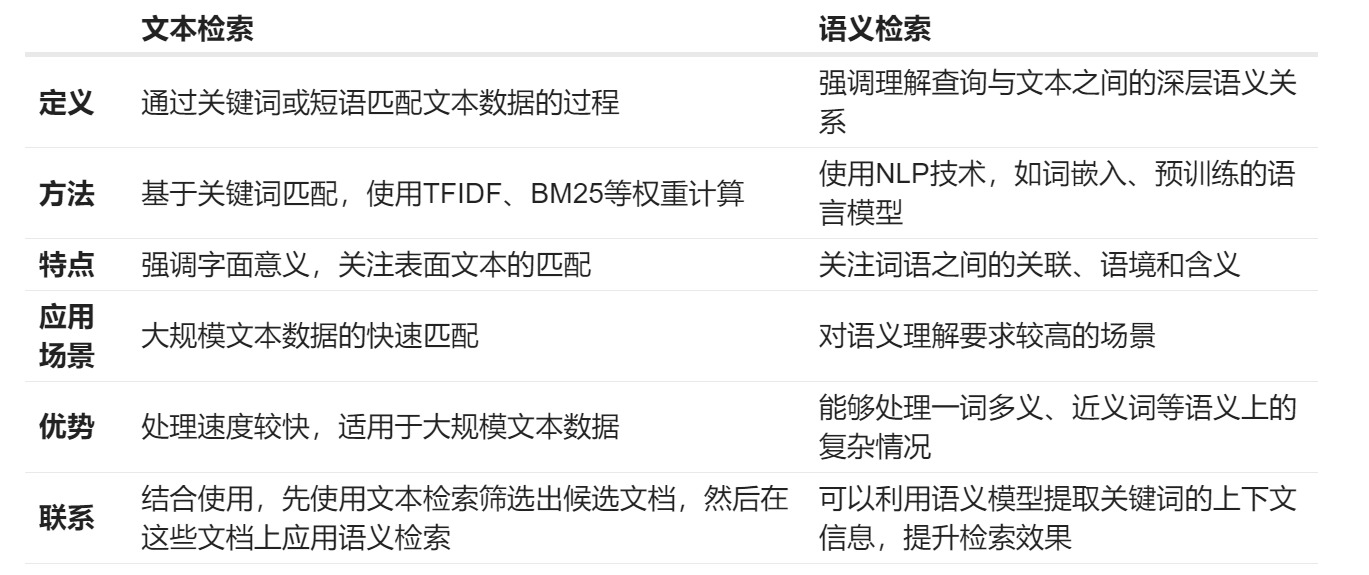
在一些场景中，文本检索和语义检索可以结合使用，以充分利用它们各自的优势。例如，可以先使用文本检索筛选出候选文档，然后在这些文档上应用语义检索来进一步提高检索的准确性。当然具体使用哪种检索方法，需要具体分析，在RAG中可以结合两种方法一起进行使用。

## TFIDF
TFIDF（Term Frequency-Inverse Document Frequency）是一种用于信息检索和文本挖掘的常用权重计算方法，旨在衡量一个词项对于一个文档集合中某个文档的重要性。该方法结合了两个方面的信息：词项在文档中的频率（TF）和在整个文档集合中的逆文档频率（IDF）。
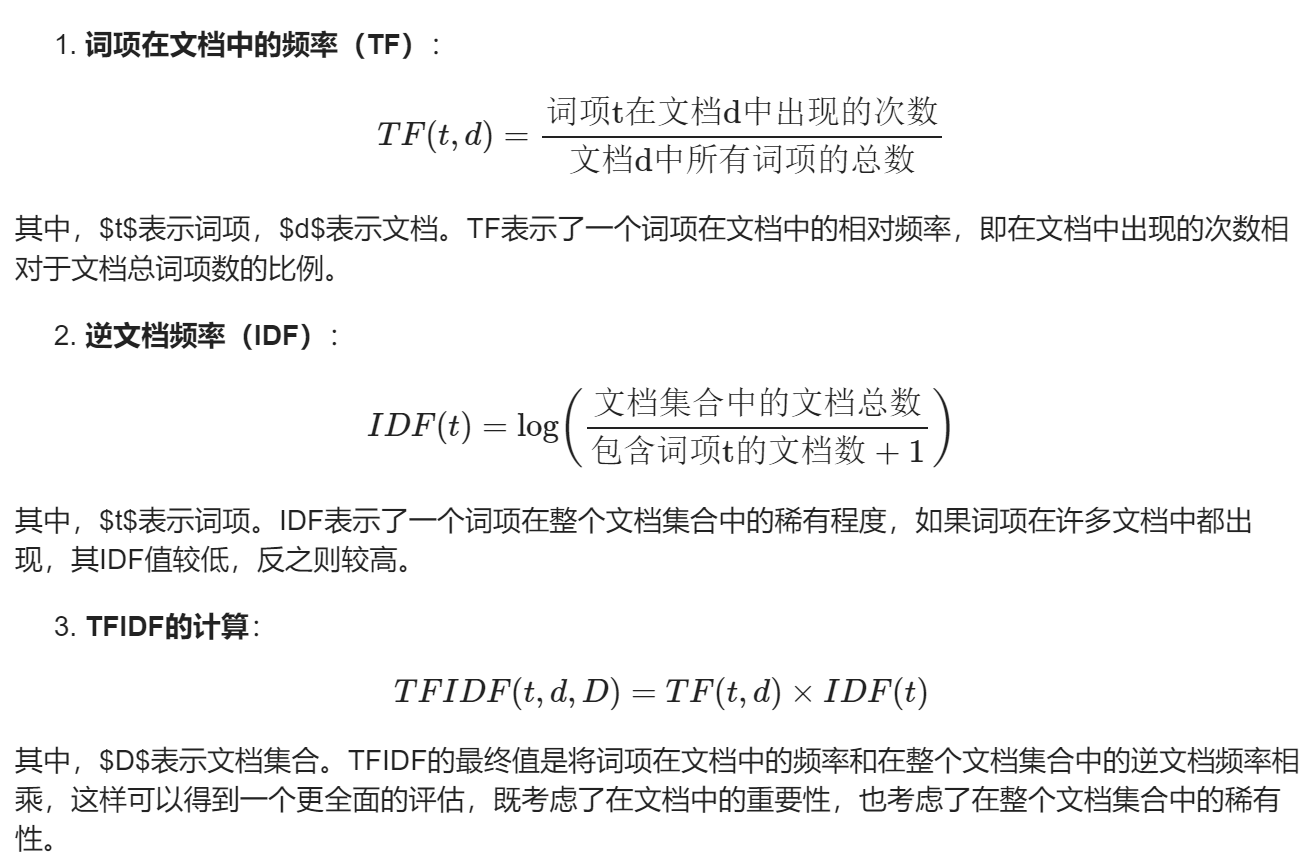

In [7]:
import jieba
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize


# 对提问和PDF进行分词
question_words= [' '.join(jieba.lcut(x['question'])) for x in questions]
pdf_content_words = [' '.join(jieba.lcut(x['content'])) for x in pdf_contents]

print(question_words[0])
print(pdf_content_words[0])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\13235\AppData\Local\Temp\jieba.cache


Loading model cost 0.450 seconds.
Prefix dict has been built successfully.


“ 前排 座椅 通风 ” 的 相关 内容 在 第几页 ？
欢迎 
 感谢您 选择 了 具有 优良 安全性 、 舒适性 、 动力性 和 经济性 的 Lynk & Co 领克 汽车 。 
 首次 使用 前 请 仔细 、 完整 地 阅读 本手册 内容 ， 将 有助于 您 更好 地 了解 和 使用 车辆 。 
 本手册 中 的 所有 资料 均 为 出版 时 的 最新 资料 ， 但本 公司 将 对 产品 进行 不断 的 改进 和 优化 ， 您 所购 的 车辆 可能 与 本手册 中 的 描述 有所不同 ， 请以 实际 
 接收 的 车辆 为准 。 
 如 您 有 任何 问题 ， 或 需要 预约 服务 ， 请拨 打电话 4006 - 010101 联系 我们 。 您 也 可以 开车 前往 Lynk & Co 领克 中心 。 
 在 抵达 之前 ， 请 您 注意 驾车 安全 。 
 © 领克 汽车 销售 有限公司


In [8]:
# 训练TFIDF
tfidf = TfidfVectorizer()
tfidf.fit(question_words + pdf_content_words)

# 提取
question_feat = tfidf.transform(question_words)
pdf_content_feat = tfidf.transform(pdf_content_words)
# print(question_feat[0])
# print(pdf_content_feat[0])
# 进行归一化
question_feat = normalize(question_feat)
pdf_content_feat = normalize(pdf_content_feat)
# print("*"*50)
# print(question_feat[0])
# print(pdf_content_feat[0])

# for i, word in enumerate(question_words):
#     print(f"TF-IDF of '{word}': {question_feat.toarray()[i][tfidf.vocabulary_[word[2]]]}")
#     break
for query_idx, feat in enumerate(question_feat):
    score = feat @ pdf_content_feat.T
    score = score.toarray()[0]
    # print(score)
    max_score_page_idx = score.argsort()[-1] + 1
    # print(score.argsort()[-1])
    questions[query_idx]['reference'] = 'page_'+str(max_score_page_idx)
    break

with open("submit_tfidf.json", "w", encoding="utf-8") as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)

# BM25
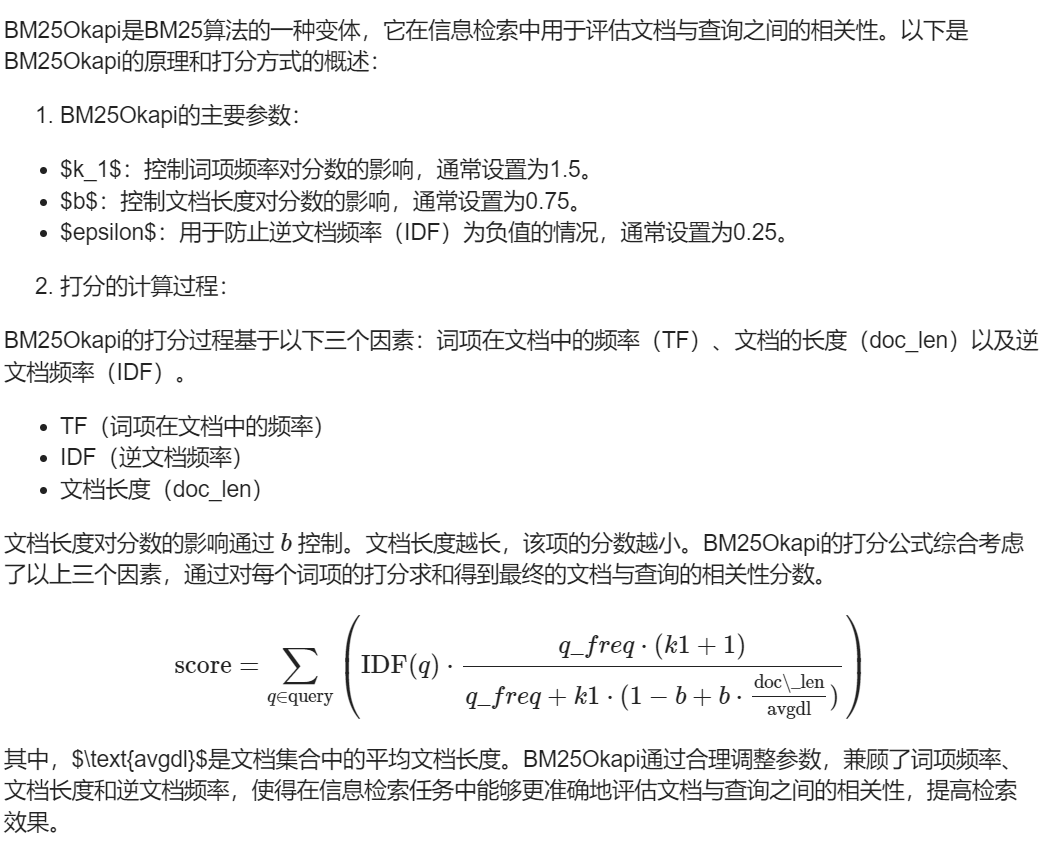

In [9]:
# BM25
from rank_bm25 import BM25Okapi
import jieba
import json

pdf_content_words =[jieba.lcut(x['content']) for x in pdf_contents]
bm25 = BM25Okapi(pdf_content_words)

for query_idx in range(len(questions)):
    doc_scores = bm25.get_scores(jieba.lcut(questions[query_idx]['question']))
    max_score_page_idx = doc_scores.argsort()[-1] + 1
    questions[query_idx]['reference'] = 'page_' + str(max_score_page_idx)

with open("submit_BM25.json", "w", encoding="utf-8") as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)



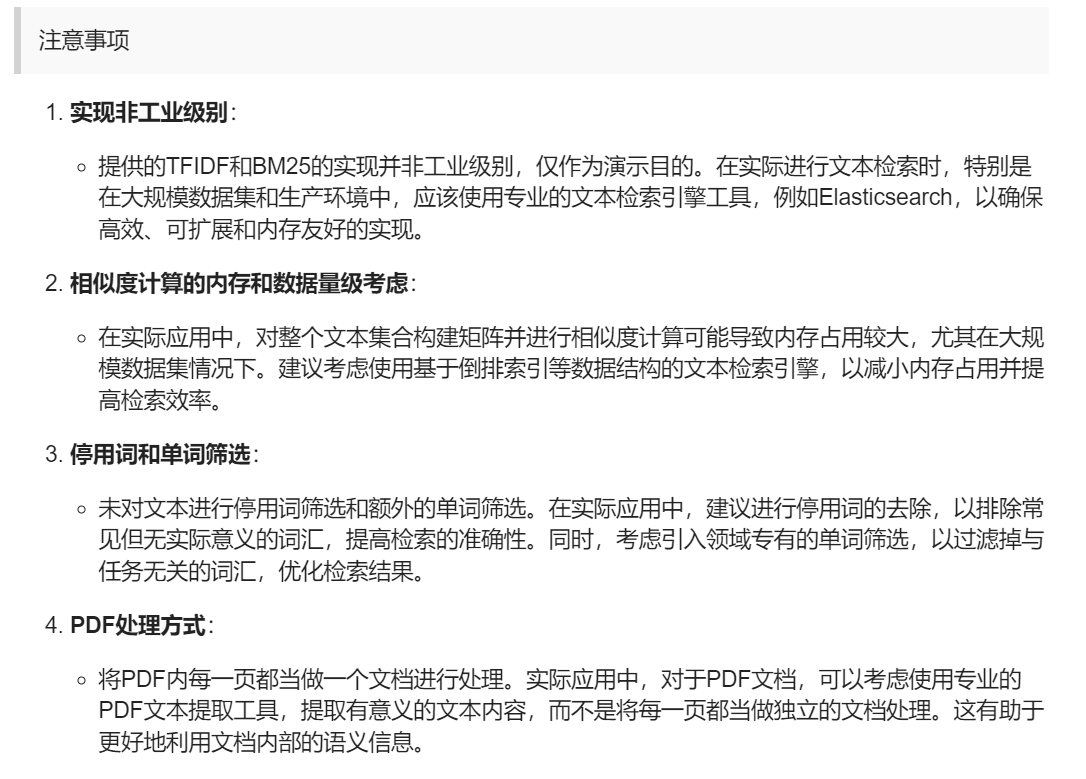

# 文本嵌入与向量检索
## 语义检索流程
- 语义检索是通过词嵌入和句子嵌入等技术，将文本表示为语义丰富的向量。通过相似度计算和结果排序找到最相关的文档。用户查询经过自然语言处理处理，最终系统返回经过排序的相关文档，提供用户友好的信息展示。语义检索通过深度学习和自然语言处理技术，使得系统能够更准确地理解用户查询，提高检索的准确性和效果。
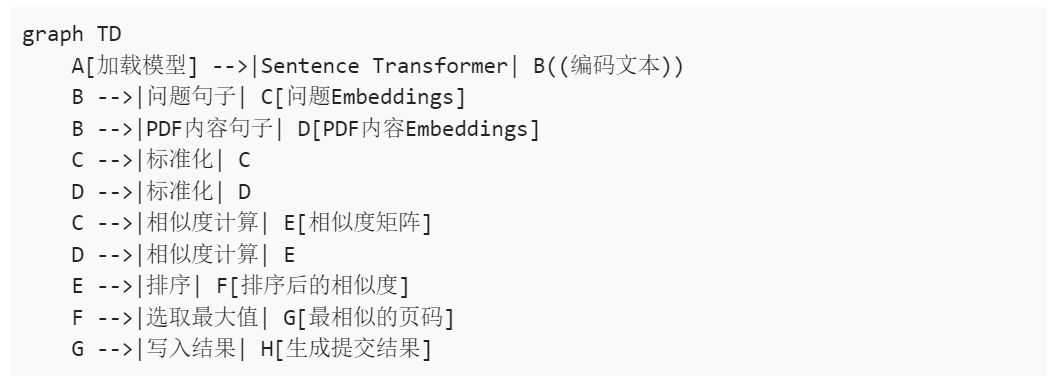

## 文本编码模型
- 文本编码模型对于语义检索的精度至关重要。目前，大多数语义检索系统采用预训练模型进行文本编码，其中最为常见的是基于BERT（Bidirectional Encoder Representations from Transformers）的模型，或者使用GPT（Generative Pre-trained Transformer）等。这些预训练模型通过在大规模语料上进行训练，能够捕捉词语和句子之间的复杂语义关系。选择合适的文本编码模型直接影响到得到的文本向量的有效性，进而影响检索的准确性和效果。

In [11]:
# M3E
from sentence_transformers import SentenceTransformer
import os
# 代理配置，用于通过指定的 HTTP 和 HTTPS 代理访问网络资源
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'

model = SentenceTransformer('moka-ai/m3e-base')

question_sentences = [x['question'] for x in questions]
pdf_content_sentences = [x['content'] for x in pdf_contents]

question_embeddings = model.encode(question_sentences, normalize_embeddings=True)
pdf_embeddings = model.encode(pdf_content_sentences, normalize_embeddings=True)

for query_idx, feat in enumerate(question_embeddings):
    score = feat @ pdf_embeddings.T
    max_score_page_idx = score.argsort()[-1] + 1
    questions[query_idx]['reference'] = 'page_' + str(max_score_page_idx)

with open('submit_m3e.json', 'w', encoding='utf8') as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)

d:\anaconda3\envs\LLM\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [12]:
# BCE
from sentence_transformers import SentenceTransformer
import os
# 代理配置，用于通过指定的 HTTP 和 HTTPS 代理访问网络资源
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'

model = SentenceTransformer('BAAI/bge-small-zh-v1.5')

question_sentences = [x['question'] for x in questions]
pdf_content_sentences = [x['content'] for x in pdf_contents]

question_embeddings = model.encode(question_sentences, normalize_embeddings=True)
pdf_embeddings = model.encode(pdf_content_sentences, normalize_embeddings=True)

for query_idx, feat in enumerate(question_embeddings):
    score = feat @ pdf_embeddings.T
    max_score_page_idx = score.argsort()[-1] + 1
    questions[query_idx]['reference'] = 'page_' + str(max_score_page_idx)

with open('submit_bge.json', 'w', encoding='utf8') as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)

d:\anaconda3\envs\LLM\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\13235\.cache\huggingface\hub\models--BAAI--bge-small-zh-v1.5. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [14]:
# BCEmbedding
from sentence_transformers import SentenceTransformer
import os
# 代理配置，用于通过指定的 HTTP 和 HTTPS 代理访问网络资源
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'

model = SentenceTransformer("maidalun1020/bce-embedding-base_v1", device='cuda')
model.max_seq_length = 512

question_sentences = [x['question'] for x in questions]
pdf_content_sentences = [x['content'] for x in pdf_contents]

question_embeddings = model.encode(question_sentences, normalize_embeddings=True)
pdf_embeddings = model.encode(pdf_content_sentences, normalize_embeddings=True)

for query_idx, feat in enumerate(question_embeddings):
    score = feat @ pdf_embeddings.T
    max_score_page_idx = score.argsort()[-1] + 1
    questions[query_idx]['reference'] = 'page_' + str(max_score_page_idx)

with open('submit_bce.json', 'w', encoding='utf8') as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)

## 文本切分方法
- 文本的长度是另一个关键因素，影响了文本编码的结果。短文本和长文本在编码成向量时可能表达不同的语义信息。即使两者包含相同的单词或有相似的语义，由于上下文的不同，得到的向量也会有所不同。因此，当在语义检索中使用短文本来检索长文本时，或者反之，可能导致一定的误差。针对文本长度的差异，有些系统采用截断或填充等方式处理，以保持一致的向量表示。
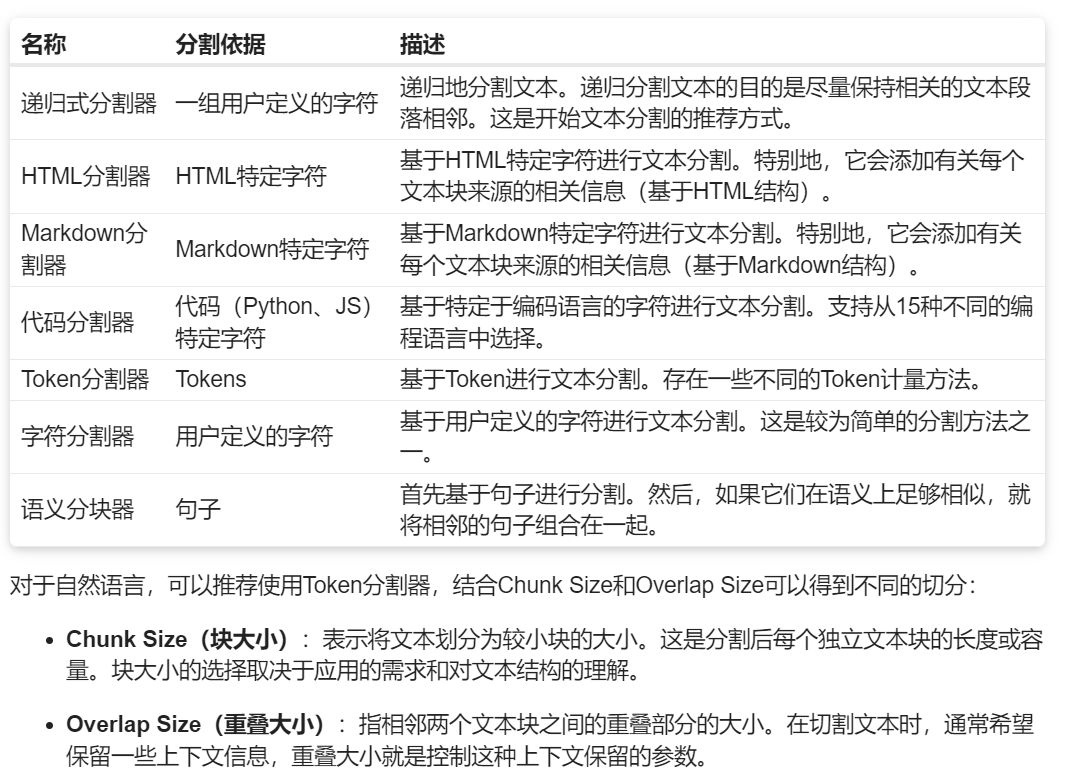

# 任务6：文本多路召回与重排序
## 多路召回逻辑
- 多路召回逻辑是在文本检索中常用的一种策略，其目的是通过多个召回路径（或方法）综合获取候选文档，以提高检索的全面性和准确性。单一的召回方法可能由于模型特性或数据特点而存在局限性，多路召回逻辑引入了多个召回路径，每个路径采用不同的召回方法。
- 实现方法1：将BM25的检索结果 和 语义检索结果 按照排名进行加权
- 实现方法2：按照段落、句子、页不同的角度进行语义编码进行检索，综合得到检索结果。
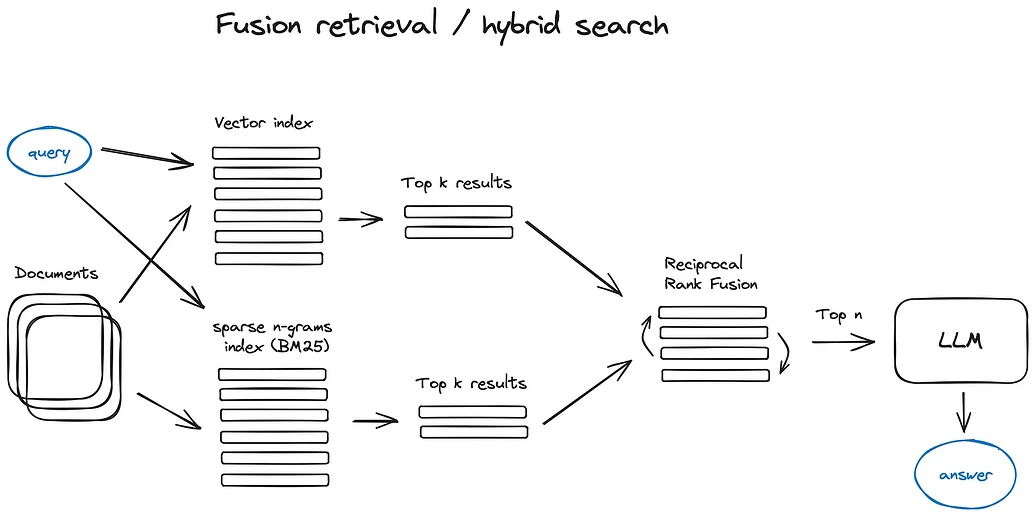

## 重排序逻辑（BM25 + BGE Rerank）
- 重排序逻辑是文本检索领域中一种重要的策略，主要用于优化原有文本检索方法返回的候选文档顺序，以提高最终的检索效果。在传统的文本检索方法中，往往采用打分的逻辑，如计算BERT嵌入向量之间的相似度。而重排序逻辑引入了更为复杂的文本交叉方法，通过特征交叉得到更进一步的打分，从而提高排序的准确性。
- 重排序逻辑常常使用更为强大的模型，如交叉编码器（cross-encoder）模型。这类模型能够更好地理解文本之间的交叉关系，捕捉更复杂的语义信息。
- 首先通过传统的嵌入模型获取初始的Top-k文档，然后使用重排序逻辑对这些文档进行重新排序。这样可以在保留初步筛选文档的基础上，更精确地排列它们的顺序。
- 
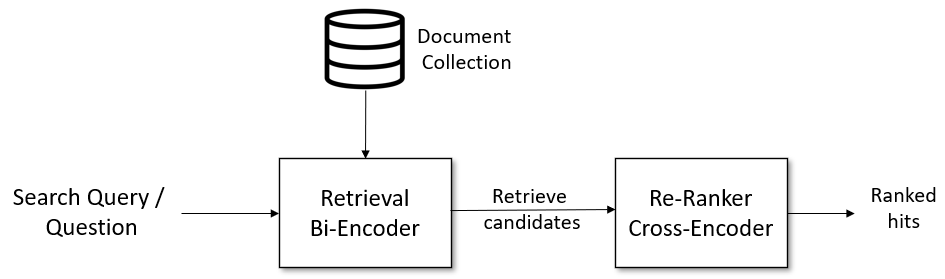

In [16]:
import jieba, json, pdfplumber
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from rank_bm25 import BM25Okapi

questions = json.load(open("./data/questions.json"))

pdf = pdfplumber.open("./data/初赛训练数据集.pdf")
pdf_content = []
for page_idx in range(len(pdf.pages)):
    pdf_content.append({
        'page': 'page_' + str(page_idx + 1),
        'content': pdf.pages[page_idx].extract_text()
    })

In [23]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import os
# 代理配置，用于通过指定的 HTTP 和 HTTPS 代理访问网络资源
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'

tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-reranker-base")
rerank_model = AutoModelForSequenceClassification.from_pretrained('BAAI/bge-reranker-base')
rerank_model.cuda()

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768,

In [30]:
# 进行BM25检索

pdf_content_words = [jieba.lcut(x['content']) for x in pdf_content]
bm25 = BM25Okapi(pdf_content_words)

for query_idx in range(len(questions)):
    
    doc_scores = bm25.get_scores(jieba.lcut(questions[query_idx]['question']))
    max_score_page_idxs = doc_scores.argsort()[-3:]

    # top3 重排序
    pairs = []
    
    # 将匹配好的内容与问题经XLMRobertaModel重新进行打分
    for idx in max_score_page_idxs:
        pairs.append([questions[query_idx]['question'], pdf_content[idx]['content']])
       
    
    # print(pairs)
    
    inputs = tokenizer(pairs, padding=True, truncation=True, return_tensors='pt', max_length=512 )
    with torch.no_grad():
        # print(inputs.keys())
        inputs = {key: inputs[key].cuda() for key in inputs.keys()}
        # print(inputs)
        scores = rerank_model(**inputs, return_dict=True).logits.view(-1, ).float()
    # print(scores)
    # break
    max_score_page_idx = max_score_page_idxs[scores.cpu().numpy().argmax()]
    questions[query_idx]['reference'] = 'page_' + str(max_score_page_idx + 1)

with open('submit_rerank.json', 'w', encoding='utf8') as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)



# 任务7：文本问答Promopt优化


In [ ]:
def ask_glm(content):
    url = "https://open.bigmodel.cn/api/paas/v4/chat/completions"
    headers = {
      'Content-Type': 'application/json',
      'Authorization': generate_token("", 1000)
    }

    data = {
        "model": "glm-3-turbo",
        "messages": [{"role": "user", "content": content}]
    }

    response = requests.post(url, headers=headers, json=data)
    return response.json()

pdf_content_words = [jieba.lcut(x['content']) for x in pdf_content]
bm25 = BM25Okapi(pdf_content_words)

for query_idx in range(len(questions)):
    doc_scores = bm25.get_scores(jieba.lcut(questions[query_idx]["question"]))
    max_score_page_idxs = doc_scores.argsort()[-3:]

    pairs = []
    for idx in max_score_page_idxs:
        pairs.append([questions[query_idx]["question"], pdf_content[idx]['content']])

    inputs = tokenizer(pairs, padding=True, truncation=True, return_tensors='pt', max_length=512)
    with torch.no_grad():
        inputs = {key: inputs[key].cuda() for key in inputs.keys()}
        scores = rerank_model(**inputs, return_dict=True).logits.view(-1, ).float()
    max_score_page_idx = max_score_page_idxs[scores.cpu().numpy().argmax()]
    questions[query_idx]['reference'] = 'page_' + str(max_score_page_idx + 1)

    prompt = '''你是一个汽车专家，帮我结合给定的资料，回答一个问题。如果问题无法从资料中获得，请输出结合给定的资料，无法回答问题。
资料：{0}

问题：{1}
    '''.format(
        pdf_content[max_score_page_idx]['content'],
        questions[query_idx]["question"]
    )
    answer = ask_glm(prompt)['choices'][0]['message']['content']
    questions[query_idx]['answer'] = answer

with open('submit.json', 'w', encoding='utf8') as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)


In [33]:
with open('submit.json', 'w', encoding='utf8') as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)

# 任务8：问答意图识别（进阶方向）
- 使用文本相似度和prompt进行意图识别
- 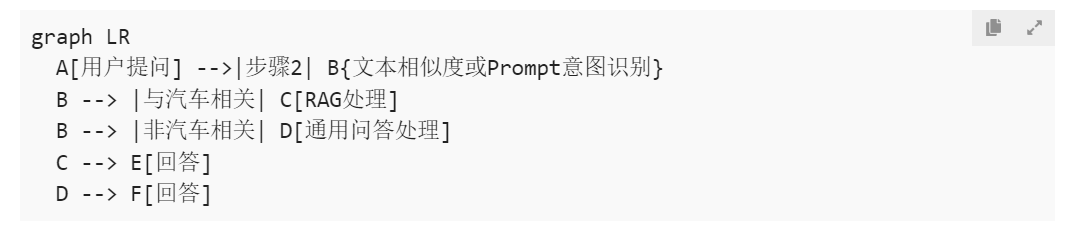
- 通过这种方式，意图识别允许系统更加灵活地适应用户的多样化需求。它允许系统在不同的上下文中识别用户意图，从而提供更准确、定制的回答。这种方法的优势在于通过使用专门的模型来处理特定领域的问题，可以提高系统的准确性和用户体验。

## 文本相似度
- 步骤1：提取用户提问的嵌入向量
- 步骤2：提取文档所有的嵌入向量
- 步骤3：判断提问向量与文档向量的最低相似度，结合相似度大小进行判断
## Prompt意图识别
你是一个汽车维修和汽车销售的专家，请判断下面的提问是否与汽车使用相关。

{用户提问}

输出：相关 / 不相关

# 任务9：问答关键词提取（进阶方向）
- 文本关键词抽取是自然语言处理领域的一项重要任务，其目标是从给定的文本中提取出最具代表性和有意义的单词或短语。这些关键词通常反映了文本的主题、内容或重要信息。常见的步骤包括分词、词性标注、停用词移除、计算词语权重以及关键词抽取算法等过程。
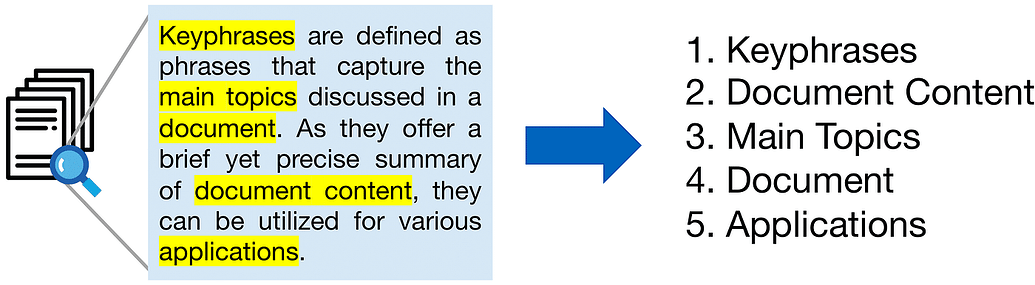
## 方法1：IDF
- 分词（Tokenization）： 将文本拆分为单词或短语。这一步骤将文本转换为基本的语言单元，为后续的处理做准备。

- 移除通用词（Stopword Removal）： 剔除常见的停用词，如"and"、“the”、"is"等，这些词在文本中普遍出现但往往没有实际的信息价值。这样做可以减少噪音，使关键词更集中在文本的内容性词汇上。

- 计算逆文档频率（IDF）： 对于每个单词，计算其逆文档频率。逆文档频率是一个衡量单词重要性的指标，它通过对整个文本集合中包含该词的文档数取倒数来计算。

- 计算TF-IDF得分： 对于每个单词，计算其TF-IDF得分，即词频（TF）与逆文档频率（IDF）的乘积。TF表示单词在当前文档中的出现频率。

- 排序和选取关键词： 根据计算得到的TF-IDF得分对单词进行排序，选择排名前几的单词作为关键词。排名越高的单词表示在当前文档中具有更高的重要性。

In [35]:
import jieba
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

import json
import pdfplumber

# 加载问题和Pdf
questions = json.load(open("./data/questions.json"))
print(questions[0])

pdf = pdfplumber.open(r"data\初赛训练数据集.pdf")
# len(pdf.pages)
# print(pdf.pages[0].extract_text())

pdf_contents = []
for page_idx in range(len(pdf.pages)):
    pdf_contents.append({'page':'page_'+str(page_idx+1),
                         'content': pdf.pages[page_idx].extract_text()
                         })

# print(pdf_contents[0])

# 对提问和PDF进行分词
question_words= [' '.join(jieba.lcut(x['question'])) for x in questions]
pdf_content_words = [' '.join(jieba.lcut(x['content'])) for x in pdf_contents]

# print(question_words[0])
# print(pdf_content_words[0])

{'question': '“前排座椅通风”的相关内容在第几页？', 'answer': '', 'reference': ''}
欢迎
感谢您选择了具有优良安全性、舒适性、动力性和经济性的Lynk&Co领克汽车。
首次使用前请仔细、完整地阅读本手册内容，将有助于您更好地了解和使用车辆。
本手册中的所有资料均为出版时的最新资料，但本公司将对产品进行不断的改进和优化，您所购的车辆可能与本手册中的描述有所不同，请以实际
接收的车辆为准。
如您有任何问题，或需要预约服务，请拨打电话4006-010101联系我们。您也可以开车前往Lynk&Co领克中心。
在抵达之前，请您注意驾车安全。
©领克汽车销售有限公司
{'page': 'page_1', 'content': '欢迎\n感谢您选择了具有优良安全性、舒适性、动力性和经济性的Lynk&Co领克汽车。\n首次使用前请仔细、完整地阅读本手册内容，将有助于您更好地了解和使用车辆。\n本手册中的所有资料均为出版时的最新资料，但本公司将对产品进行不断的改进和优化，您所购的车辆可能与本手册中的描述有所不同，请以实际\n接收的车辆为准。\n如您有任何问题，或需要预约服务，请拨打电话4006-010101联系我们。您也可以开车前往Lynk&Co领克中心。\n在抵达之前，请您注意驾车安全。\n©领克汽车销售有限公司'}
“ 前排 座椅 通风 ” 的 相关 内容 在 第几页 ？
欢迎 
 感谢您 选择 了 具有 优良 安全性 、 舒适性 、 动力性 和 经济性 的 Lynk & Co 领克 汽车 。 
 首次 使用 前 请 仔细 、 完整 地 阅读 本手册 内容 ， 将 有助于 您 更好 地 了解 和 使用 车辆 。 
 本手册 中 的 所有 资料 均 为 出版 时 的 最新 资料 ， 但本 公司 将 对 产品 进行 不断 的 改进 和 优化 ， 您 所购 的 车辆 可能 与 本手册 中 的 描述 有所不同 ， 请以 实际 
 接收 的 车辆 为准 。 
 如 您 有 任何 问题 ， 或 需要 预约 服务 ， 请拨 打电话 4006 - 010101 联系 我们 。 您 也 可以 开车 前往 Lynk & Co 领克 中心 。 
 在 抵达 之前 ， 请 您 注意 驾车 安全 。 
 © 领克 汽车 销售 有限公司


In [63]:
# 训练TFIDF
tfidf = TfidfVectorizer()
tfidf.fit(question_words + pdf_content_words)

# 提取
question_feat = tfidf.transform(question_words)

for query_idx, feat in enumerate(question_feat):

    keywords = feat.toarray()[0].argsort()[-5:][::-1]  # 反转数组以按降序排列
    ke = tfidf.get_feature_names_out()[keywords]
    
    # 存储问题及其关键词
    questions.append({
        'question': question_words[query_idx],
        'keywords': ke.tolist()
    })
    
    # 打印结果
    print(feat)
    print(ke)
    print(question_words[query_idx])
    
    if query_idx >= 0:  # 只打印第一个问题作为示例
        break


with open("keywords_tfidf1.json", "w", encoding="utf-8") as up:
    json.dump(questions, up, ensure_ascii=False, indent=4)

  (0, 1136)	0.4526033009607539
  (0, 1273)	0.32929184994563093
  (0, 2103)	0.29322556256895066
  (0, 3347)	0.32929184994563093
  (0, 3484)	0.5425856162365112
  (0, 4181)	0.44486360335226943
['第几页' '内容' '通风' '相关' '前排']
“ 前排 座椅 通风 ” 的 相关 内容 在 第几页 ？


## 方法2：KeyBERT
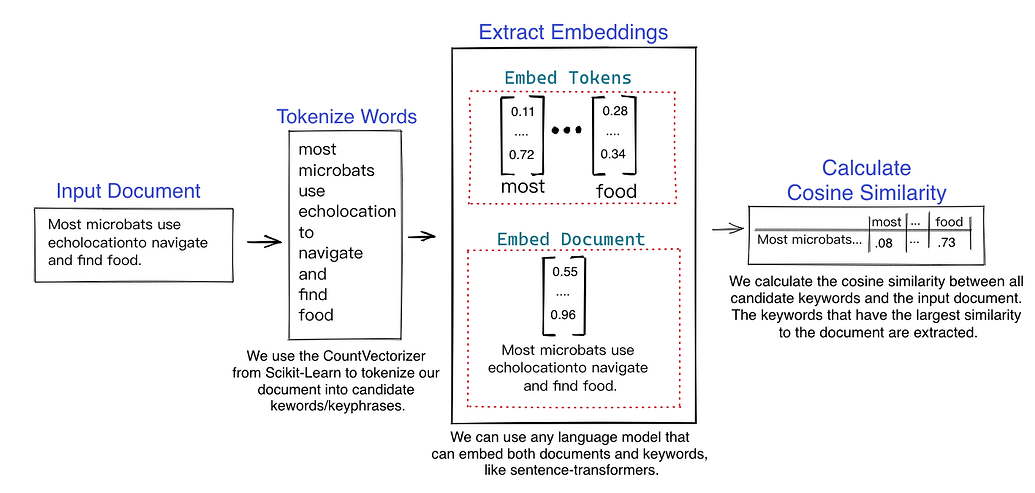
- Embedding文本： 首先，KEYBERT使用预训练的BERT模型，例如distilbert-base-nli-mean-tokens，将输入的文本嵌入到一个高维的向量空间中。BERT模型能够学习丰富的语义表示，因此生成的向量能够捕捉文本的语义信息。

- 计算余弦相似度： 然后，KEYBERT计算文档中每个候选关键词或关键短语与整个文档之间的余弦相似度。余弦相似度是一种衡量两个向量之间夹角的度量，它在这里用于度量嵌入向量之间的相似性。

- 排序关键词： 最后，根据计算得到的余弦相似度值，KEYBERT将关键词或关键短语排序，从而形成最终的关键词列表。余弦相似度越高，表示关键词与文档的语义相似度越大，因此在排序中位置越靠前。

## 方法3：Prompt关键词提取
你是一个专业的文本理解专家，现在请你识别下面内容中的关键词，将关键词使用空格隔开：
{输入文本}
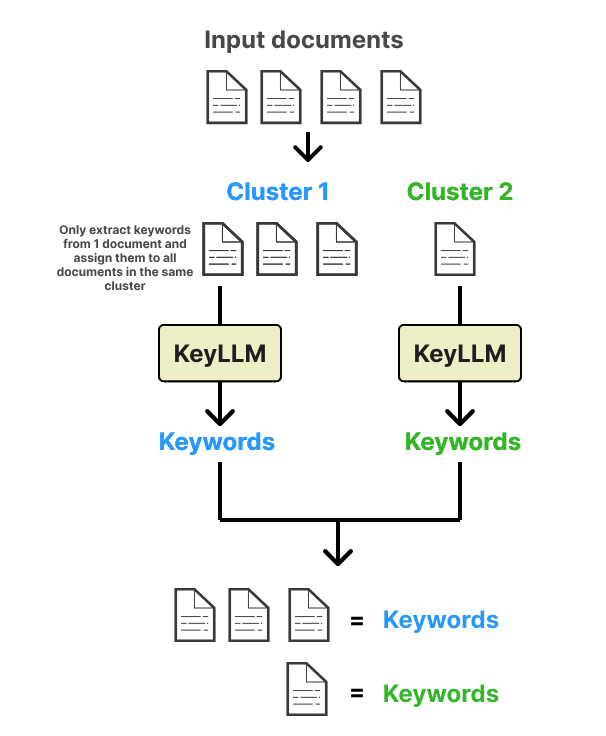
- 为了提高关键词提取过程的效率，可以采用一种优化策略。首先，将所有文档通过预训练的嵌入模型映射到向量空间中，生成它们的向量表示。接着，通过计算文档之间的相似性，使用余弦相似度等度量方法，将相似的文档聚合成一个文档聚类。在每个文档聚类中，选择一个代表性文档，利用关键词提取模型生成关键词。


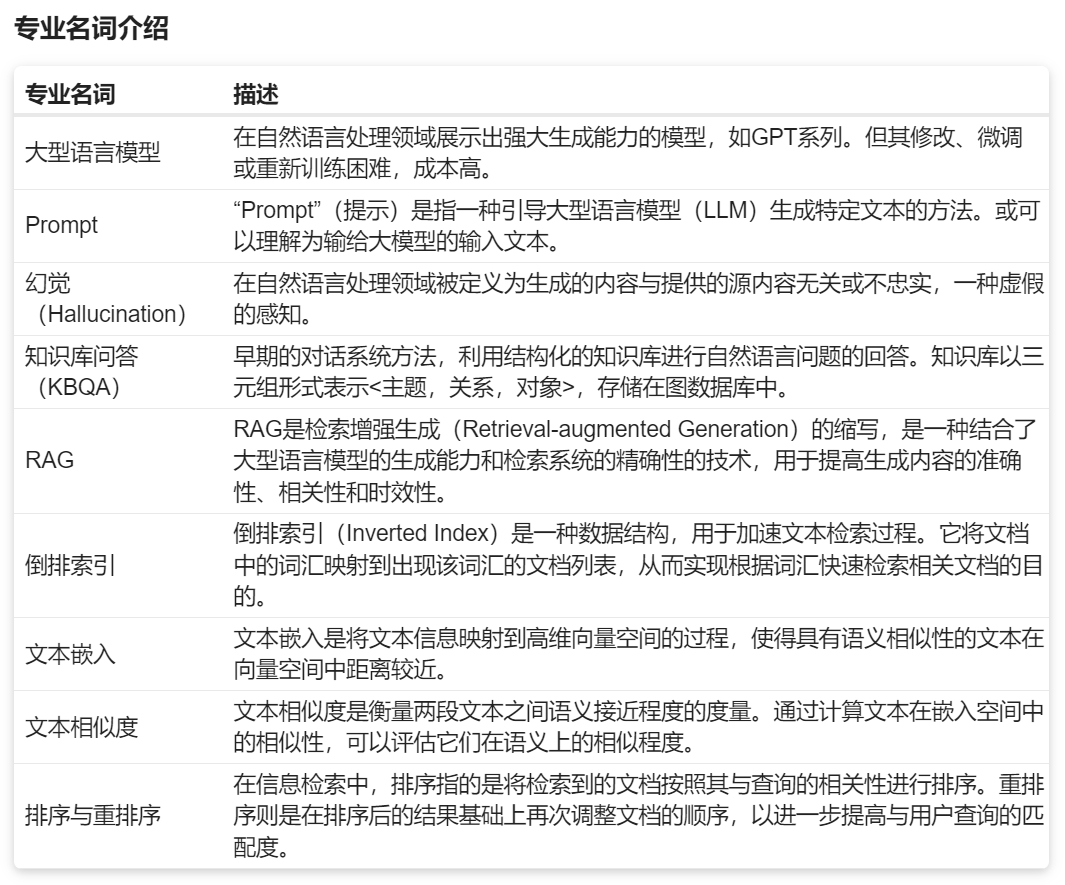